In [1]:
# This file is modified version of original:
# https://www.kaggle.com/code/baurzhanurazalinov/parkinson-s-freezing-defog-training-code/notebook

In [2]:
# most part of this file code is similar to tdcsfog_train.ipynb and thus already explained in tdcsfog_train.ipynb.

**Configuration**

In [3]:
# run with different configurations
# Model 1 => 
# val_subjects = ['00f674', '8d43d9', '107712', '7b2e84', '575c60', '7f8949', '2874c5', '72e2c7']
# Train data: defog data, notype data
# Validation data: defog data, notype data

# Model 2 => 
# Train data: defog data (about 85%)
# Validation data: defog data (about 15%), notype data (100%)

# Model 3 => 
# Train data: defog data (100%)
# Validation data: notype data (100%)
# Train 18 minutes on TPU. 

# Model 4 => 
# val_subjects = ['12f8d1', '8c1f5e', '387ea0', 'c56629', '7da72f', '413532', 'd89567', 'ab3b2e', 'c83ff6', '056372']
# Train data: defog data, notype data
# Validation data: defog data, notype data

In [4]:
CFG = {'TPU': 1,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 4,#5
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

LEARNING_RATE = 0.01/62
STEPS_PER_EPOCH = 256
EPOCHS = 50
WEIGHTS = ''

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

# validation subjects
val_subjects = ['00f674', '8d43d9', '107712', '7b2e84', '575c60', '7f8949', '2874c5', '72e2c7']

'''
Train and inference batch size

'''

GPU_BATCH_SIZE = 2#16


'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    # tf.math.reduce_mean( input_tensor, axis=None,) => 
    # reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis.
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    # tf.math.divide_no_nan(x,y) => computes a safe divide which returns 0 if y (denominator) is zero.
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    
    # series.head(3) =>
    #        AccV     AccML     AccAP  StartHesitation  Turn  Walking  Valid  Mask
    # 0 -0.276487 -0.169868 -1.734705                0     0        0      1     1
    # 1 -0.278077 -0.171851 -1.746803                0     0        0      1     1
    # 2 -0.273169 -0.174003 -1.741763                0     0        0      1     1    
    
    # series.values =>
    # [[-0.27648746 -0.16986818 -1.73470538 ...  0.          1.
    #    1.        ]
    #  [-0.27807749 -0.17185063 -1.74680347 ...  0.          1.
    #    1.        ]
    #  ...
    #  [-0.1392557  -0.35189566 -2.12723026 ...  0.          1.
    #    1.        ]
    #  [-0.14250613 -0.33945229 -2.14632764 ...  0.          1.
    #    1.        ]]
    
    # series.values.shape => (4682, 8)
    # type(series.values) => <class 'numpy.ndarray'>

    series = series.values
    series = series.astype(np.float32)
    
    # .ceil => rounds a number UP to the nearest integer.
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    # [0, ...] => pad axis=0 with 0 values before and ... values after.
    # [0, 0] => pad axis=1 with 0 values before and 0 values after.
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks



**Imports and Utils**

In [5]:
import os
import math
import random
import warnings

# if CFG['TPU']:
#     !pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
#     !pip install -qU scikit-learn
    
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm
from itertools import cycle
from joblib import Parallel, delayed
from sklearn.metrics import average_precision_score

if CFG['TPU']:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local') 
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    TPU_BATCH_SIZE = GPU_BATCH_SIZE = tpu_strategy.num_replicas_in_sync*GPU_BATCH_SIZE

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

def folder(path): 
    if not os.path.exists(path): os.makedirs(path)
        
def plot(e, size=(20, 4)):
    plt.figure(figsize=size)
    plt.plot(e)
    plt.show()

D0714 16:08:24.417517625      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0714 16:08:24.417538296      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0714 16:08:24.417541524      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0714 16:08:24.417544037      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0714 16:08:24.417546402      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0714 16:08:24.417548971      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0714 16:08:24.417552062      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0714 16:08:24.

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

**Model**

In [6]:
'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.Model):#tf.keras.Model tf.keras.layers.Layer # comment by me
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)        
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = tf.keras.Sequential([EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])])
        
        self.lstm_layers = tf.keras.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])])
        
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
        x = self.first_dropout(x)
        
        #for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        #for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.enc_layers(x)                        
        x = self.lstm_layers(x)        
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(4) 
        
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 4)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x
    
    def model(self):
        # input_shape=(not include batch size).
        x = tf.keras.Input(shape=( CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), 
                                       batch_size=GPU_BATCH_SIZE)
        return tf.keras.Model(inputs=x, outputs=self.call(x))

**Train Defog Data - Preparing**

In [8]:
'''
Create defog and notype train blocks with 
AccV, AccML, AccAP, StartHesitation, Turn, Walking, Event, StartHesitation_mask, Turn_mask, Walking_mask, Event_mask columns 

'''

save_path = '/kaggle/working/train/defog'; folder(save_path); 
defog_metadata = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv').set_index('Id')
#save_path = './kaggle/working/train/defog'; folder(save_path); 
#defog_metadata = pd.read_csv('defog_metadata.csv').set_index('Id')

def get_blocks_descriptions(Id):
    blocks_descriptions = []
    
    try: 
        #series = pd.read_csv(f'./train/defog/{Id}.csv')
        series = pd.read_csv(f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{Id}.csv')
        series['Event'] = series[['StartHesitation', 'Turn', 'Walking']].aggregate('max', axis=1)
        
        # series.head(3) =>
        #    Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  Valid  Task   Event
        # 0     0 -1.017303  0.105948 -0.067194                0     0        0  False  False  0
        # 1     1 -1.019972  0.105369 -0.068920                0     0        0  False  False  0 
        # 2     2 -1.017942  0.103586 -0.069410                0     0        0  False  False  0    
    
        # (series['Task'] & series['Valid'])[0:5] =>        
        # 0    False
        # 1    False
        # 2    False
        # dtype: bool        
        
        series['StartHesitation_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Turn_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Walking_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Event_mask'] = (series['Task'] & series['Valid']).astype('int')
        
        source = 'defog'
        
    except FileNotFoundError: 
        #series = pd.read_csv(f'./train/notype/{Id}.csv')
        series = pd.read_csv(f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype/{Id}.csv')
        
        # series.head(3) =>
        #    Time      AccV     AccML     AccAP  Event  Valid   Task
        # 0     0 -0.914652 -0.300851  0.298156      0  False  False
        # 1     1 -0.914367 -0.301572  0.298325      0  False  False
        # 2     2 -0.779540 -0.343197  0.275690      0  False  False        
        
        series['StartHesitation'] = 0
        series['Turn'] = 0
        series['Walking'] = 0
        
        series['StartHesitation_mask'] = 0
        series['Turn_mask'] = 0
        series['Walking_mask'] = 0
        series['Event_mask'] = (series['Task'] & series['Valid']).astype('int')
        
        source = 'notype'
        
    
    series['AccV'] = sample_normalize(series['AccV'].values)
    series['AccML'] = sample_normalize(series['AccML'].values)
    series['AccAP'] = sample_normalize(series['AccAP'].values)

    blocks = get_blocks(series, ['AccV', 'AccML', 'AccAP', 
                                 'StartHesitation', 'Turn', 'Walking', 'Event', 
                                 'StartHesitation_mask', 'Turn_mask', 'Walking_mask', 'Event_mask'])

    for block_count, block in enumerate(blocks):
        fname, values = f'{Id}_{block_count}.npy', block['values']
        block_description = {}
        block_description['Id'] = Id
        block_description['Count'] = block_count
        block_description['File'] = fname
        block_description['Path'] = f'{save_path}/{fname}'
        block_description['Source'] = source
        
        block_description['StartHesitation_size'] = np.sum(values[:, 3])
        block_description['Turn_size'] = np.sum(values[:, 4])
        block_description['Walking_size'] = np.sum(values[:, 5])
        block_description['Event_size'] = np.sum(values[:, 6])
        
        block_description['StartHesitation_mask_size'] = np.sum(values[:, 7])
        block_description['Turn_mask_size'] = np.sum(values[:, 8])
        block_description['Walking_mask_size'] = np.sum(values[:, 9])
        block_description['Event_mask_size'] = np.sum(values[:, 10])
        
        blocks_descriptions.append(block_description)
        
        # Load
        series = values # [AccV, AccML, AccAP, StartHesitation, Turn, Walking, Event, StartHesitation_mask, Turn_mask, Walking_mask, Event_mask]
        
        # Create patches
        series = tf.reshape(series, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], series.shape[1]))
        
        # series.shape => (864, 14, 11)

        # Create input
        series_input = series[:, :, :3]
        series_input = tf.reshape(series_input, shape=(CFG['block_size'] // CFG['patch_size'], -1))

        # Create target
        series_target = series[:, :, 3:]
        series_target = tf.transpose(series_target, perm=[0, 2, 1])
        series_target = tf.reduce_max(series_target, axis=-1)
        
        # series_target.shape => (864, 8)
        # 'StartHesitation', 'Turn', 'Walking', 'Event', 'StartHesitation_mask', 'Turn_mask', 'Walking_mask', 'Event_mask'
        
        RAM[(Id, block_count)] = (series_input, series_target)
    
    blocks_descriptions = pd.DataFrame(blocks_descriptions)
    
    return blocks_descriptions

RAM = {}
blocks_descriptions = [get_blocks_descriptions(defog_metadata.index[i]) for i in tqdm(range(len(defog_metadata.index)), desc='Preparation')]
blocks_descriptions = pd.concat(blocks_descriptions)

Preparation: 100%|██████████| 137/137 [02:10<00:00,  1.05it/s]


**Train Dataset**

In [9]:
'''
Selecting validation subjects

'''

train_ids = defog_metadata[defog_metadata['Subject'].apply(lambda x: x not in val_subjects)].index.tolist()
val_ids = defog_metadata[defog_metadata['Subject'].apply(lambda x: x in val_subjects)].index.tolist()

train_blocks_descriptions = blocks_descriptions[blocks_descriptions['Id'].apply(lambda x: x in train_ids)]

print(f'\n[Train ids] {len(train_ids)} [Val ids] {len(val_ids)} ({100*len(val_ids)/(len(train_ids)+len(val_ids)):.1f})')
print(f'[Train blocks] {len(train_blocks_descriptions )}\n')


[Train ids] 115 [Val ids] 22 (16.1)
[Train blocks] 25955



In [10]:
'''
Create a random train dataset from train_blocks_descriptions DataFrame

'''

def read(row):
    def read_from_ram(Id, Count):  
        series_inputs, series_targets = RAM[(Id.numpy().decode('utf-8'), Count.numpy())]
        return series_inputs, series_targets

    [series_input, series_target] = tf.py_function(read_from_ram, [row['Id'], row['Count']], [tf.float32, tf.float32])
    series_input.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
    series_target.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], 8))
    
    return series_input, series_target

ids_groups, num_subgroups = [id_group for Id, id_group in train_blocks_descriptions.groupby('Id')], CFG['block_size'] // CFG['block_stride']
# type(ids_groups) => <class 'list'>
# type(ids_groups[0]) => <class 'pandas.core.frame.DataFrame'>
random.shuffle(ids_groups)

dataset = []
## better sampling
# num_subgroups => 16
for i in range(num_subgroups):
    for group in ids_groups:        
        # .iloc[start:stop:step]
        # select 0th row, then (0+16)16th row, then 32nd row and so on.
        subgroup = group.iloc[i::num_subgroups]        
        dataset.append(subgroup)

dataset = pd.concat(dataset)
dataset = dataset[dataset['Event_mask_size'] != 0]
dataset = dataset.reset_index(drop=True); display(dataset.head(9));
dataset = tf.data.Dataset.from_tensor_slices(dict(dataset))
dataset = dataset.map(read).repeat().batch(TPU_BATCH_SIZE*tpu_strategy.num_replicas_in_sync if CFG['TPU'] else GPU_BATCH_SIZE, drop_remainder=True)

,Id,Count,File,Path,Source,StartHesitation_size,Turn_size,Walking_size,Event_size,StartHesitation_mask_size,Turn_mask_size,Walking_mask_size,Event_mask_size
0,28209b9006,0,28209b9006_0.npy,/kaggle/working/train/defog/28209b9006_0.npy,defog,0.0,0.0,0.0,0.0,11096.0,11096.0,11096.0,11096.0
1,28209b9006,16,28209b9006_16.npy,/kaggle/working/train/defog/28209b9006_16.npy,defog,0.0,0.0,0.0,0.0,8664.0,8664.0,8664.0,8664.0
2,28209b9006,32,28209b9006_32.npy,/kaggle/working/train/defog/28209b9006_32.npy,defog,0.0,0.0,0.0,0.0,4352.0,4352.0,4352.0,4352.0
3,28209b9006,64,28209b9006_64.npy,/kaggle/working/train/defog/28209b9006_64.npy,defog,0.0,0.0,0.0,0.0,1289.0,1289.0,1289.0,1289.0
4,28209b9006,80,28209b9006_80.npy,/kaggle/working/train/defog/28209b9006_80.npy,defog,0.0,0.0,0.0,0.0,2608.0,2608.0,2608.0,2608.0
5,28209b9006,96,28209b9006_96.npy,/kaggle/working/train/defog/28209b9006_96.npy,defog,0.0,0.0,0.0,0.0,2848.0,2848.0,2848.0,2848.0
6,28209b9006,128,28209b9006_128.npy,/kaggle/working/train/defog/28209b9006_128.npy,defog,0.0,348.0,0.0,348.0,4300.0,4300.0,4300.0,4300.0
7,28209b9006,144,28209b9006_144.npy,/kaggle/working/train/defog/28209b9006_144.npy,defog,0.0,157.0,0.0,157.0,4672.0,4672.0,4672.0,4672.0
8,28209b9006,160,28209b9006_160.npy,/kaggle/working/train/defog/28209b9006_160.npy,defog,0.0,0.0,0.0,0.0,1008.0,1008.0,1008.0,1008.0


**Train**

In [14]:
'''
loss_function args exp

real is a tensor with the shape (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 8) where the last axis means:
0 - StartHesitation 
1 - Turn
2 - Walking
3 - Event
4 - StartHesitation mask
5 - Turn mask
6 - Walking mask
7 - Event mask

output is a tensor with the shape (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 4) where the last axis means:
0 - StartHesitation predicted
1 - Turn predicted
2 - Walking predicted
3 - Event predicted

'''

ce = tf.keras.losses.BinaryCrossentropy(reduction='none')

def loss_function(real, output, name='loss_function'):
    loss = ce(tf.expand_dims(real[:, :, 0:4], axis=-1), tf.expand_dims(output, axis=-1)) # Example shape (32, 864, 4)
    
    mask = real[:, :, 4:8] # Example shape (32, 864, 4)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask # Example shape (32, 864, 4)
    
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

'''
Simple learning rate schedule with warm up steps

'''
        
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps=1):
        super(CustomSchedule, self).__init__()

        self.initial_lr = tf.cast(initial_lr, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return tf.math.minimum(self.initial_lr, self.initial_lr * (step/self.warmup_steps))
    
'''
PredictionFnCallback is used for:
1. Loading validation data
2. FOGModel data preparation
3. Prediction
4. Scoring and save

'''
    
class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            try:
                series = pd.read_csv(path).reset_index(drop=True)
            except FileNotFoundError:
                return
            
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            try:
                series['Event'] = series[['StartHesitation', 'Turn', 'Walking']].aggregate('max', axis=1)
            except:
                pass
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Validation data blocks
        self.blocks_counter=0 # Blocks counter
                
        defog_ids = val_ids
        #defog_paths = [f'./kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{defog_id}.csv' for defog_id in defog_ids]
        defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)
                
        defog_ids = val_ids
        #defog_paths = [f'./kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype/{defog_id}.csv' for defog_id in defog_ids]
        defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE*tpu_strategy.num_replicas_in_sync if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE*tpu_strategy.num_replicas_in_sync if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        
        print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE*tpu_strategy.num_replicas_in_sync if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
        predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy()
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            series['Event_prediction'] = series[['StartHesitation_prediction', 'Turn_prediction', 'Walking_prediction']].aggregate('max', axis=1)
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets).reset_index(drop=True)
        
        return targets
    
    def on_epoch_end(self, epoch, logs=None):
        scores=[]
        scores.append(f'{(epoch+1):03d}')
        
        loss = logs['loss'] if epoch >= 0 else 1.0
        
        targets = self.prediction()
        targets = targets[(targets['Task'] & targets['Valid'])]
        
        # Score
        
        defog_targets = targets[~targets['Turn'].isna()]
            
        Turn_mAP = average_precision_score(defog_targets['Turn'], defog_targets['Turn_prediction'])
        Walking_mAP = average_precision_score(defog_targets['Walking'], defog_targets['Walking_prediction'])
        mAP = (Walking_mAP+Turn_mAP)/2

        print(f'\n\n[0] Turn mAP - {Turn_mAP:.3f} Walking mAP - {Walking_mAP:.3f} mAP - {mAP:.3f}')
        
        scores.append(f'{mAP:.3f}')
        
        # Score
        
        Event_mAP = average_precision_score(targets['Event'], targets['Event_prediction'])
        
        print(f'[1] Event mAP - {Event_mAP:.3f}\n')
        
        scores.append(f'{Event_mAP:.3f}')
        
        # Save
        
        scores.append(f'{loss:.4f}')
        
        save_name = '_'.join(scores)
        #save_path = f'./kaggle/working/{save_name}_model.h5'
        save_path = f'/kaggle/working/{save_name}_model.h5'
        self.model.save_weights(save_path)
        
'''
Training
        
'''
        


if CFG['TPU']:
    with tpu_strategy.scope():
        model = FOGModel()#.model()
        model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
        model.summary()
        if len(WEIGHTS): model.load_weights(WEIGHTS)
        model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(LEARNING_RATE, STEPS_PER_EPOCH), beta_1=0.9, beta_2=0.98, epsilon=1e-9))
        #!rm -r /kaggle/working/*
        model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[PredictionFnCallback()])
else:
    model = FOGModel().model()
    #model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
    if len(WEIGHTS): model.load_weights(WEIGHTS)
    model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(LEARNING_RATE, STEPS_PER_EPOCH), beta_1=0.9, beta_2=0.98, epsilon=1e-9))
    #!rm -r /kaggle/working/*
    model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[PredictionFnCallback()])

Model: "fog_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fog_encoder_1 (FOGEncoder)  multiple                  15070400  
                                                                 
 dense_19 (Dense)            multiple                  2564      
                                                                 
Total params: 15,072,964
Trainable params: 15,072,964
Non-trainable params: 0
_________________________________________________________________

[PredictionFnCallback Initialization] [Series] 22 [Blocks] 4550

Epoch 1/50


2023-07-14 16:18:36.521589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-14 16:18:36.881713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


256/256 [==============================] - ETA: 0s - loss: 0.2713

2023-07-14 16:20:13.740841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-14 16:20:13.844136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.




[0] Turn mAP - 0.499 Walking mAP - 0.019 mAP - 0.259
[1] Event mAP - 0.609

256/256 [==============================] - 122s 343ms/step - loss: 0.2713
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 0.1944

[0] Turn mAP - 0.472 Walking mAP - 0.037 mAP - 0.255
[1] Event mAP - 0.701

256/256 [==============================] - 92s 360ms/step - loss: 0.1944
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.1618

[0] Turn mAP - 0.541 Walking mAP - 0.049 mAP - 0.295
[1] Event mAP - 0.766

256/256 [==============================] - 81s 316ms/step - loss: 0.1618
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 0.1288

[0] Turn mAP - 0.635 Walking mAP - 0.152 mAP - 0.394
[1] Event mAP - 0.791

256/256 [==============================] - 81s 317ms/step - loss: 0.1288
Epoch 5/50
256/256 [==============================] - ETA: 0s - loss: 0.1101

[0] Turn mAP - 0.648 Walking mAP - 0.202 mAP - 0.425
[1] Event mAP - 0.809

256/256 [====

KeyboardInterrupt: 

**Search models**

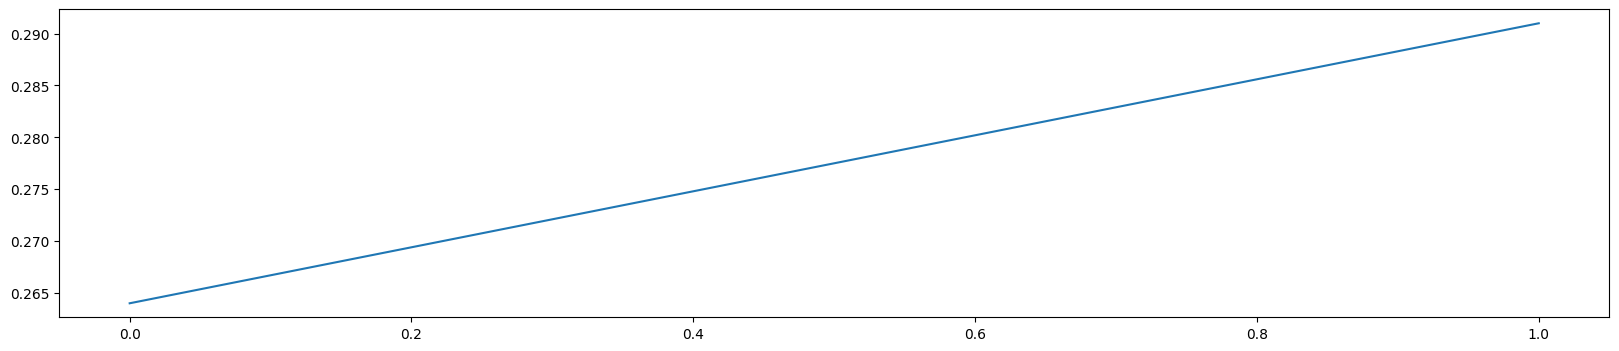

,Path,1,2,3,4,5
0,/kaggle/working/002_0.291_0.722_0.1932_model.h5,2.0,0.291,0.722,0.1932,model.h5
1,/kaggle/working/001_0.264_0.650_0.2740_model.h5,1.0,0.264,0.650,0.2740,model.h5


In [12]:
'''
Search for saved models in the working directory and sort them

'''

models = []
for fname in os.listdir('/kaggle/working/'):
    if 'model.h5' in fname:
        m = {}
        m['Path'] = '/kaggle/working/' + fname
        for i, elem in enumerate(fname.split('_')): 
            try:
                m[i+1] = float(elem)
            except:
                m[i+1] = elem
        models.append(m)

if len(models): 
    models = pd.DataFrame(models)
    plot(models.sort_values(1)[2].values)
    models = models.sort_values(2, ascending=False)
    display(models.head(15))